In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = pd.read_csv("diabetes.csv")

#### Which data types are the columns?

In [3]:
f.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

#### Do we have any null values? 

In [4]:
f.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### So, no nulls and all values are numerical - no need for imputation or manipulations on our features..

### Let's take a look on the features' distributions:

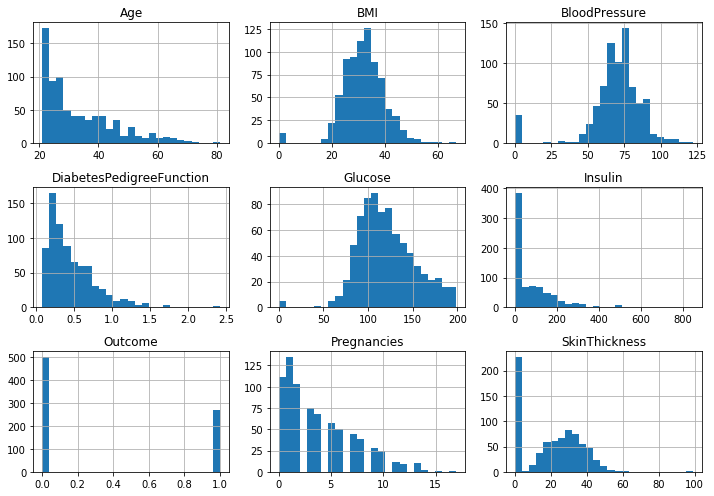

In [5]:
f.hist(bins = 25,figsize = (10,7))
plt.tight_layout()
plt.show()

#### Some outliers can be seen,so let's try to remove them: 
* Define outliers as data points below/above -4/+4 std (Quite rough definition for an outlier)
* Then, outlier can be either removed or imputed - let's simply remove them

In [6]:
def drop_outliers(ds):
    if len(ds.unique())>5: # Don't apply the condition on variables with less than 5 values
        high_out = ds.mean() + ds.std()*4
        low_out = ds.mean() - ds.std()*4
        return ds[(ds<high_out) & (ds > low_out)]
    else:
        return ds

In [7]:
# Apply the function above on each column. Outliers are returned as null values - 
# so each line containing null will be dropped.

f_dropped_outliers = f.apply(drop_outliers).dropna()


### Impute Zero values here: 

In [8]:
f_impute_zeros = f.copy()

In [9]:
for col in ['BMI','SkinThickness','BloodPressure','Glucose']:
    f_impute_zeros.loc[f_impute_zeros[col]==0,col] = f_impute_zeros.loc[f[col]>0,col].mean()
    #f = f[f[col]>0]

In [10]:
f_dropped_zeros = f_dropped_outliers.copy()
for col in ['BMI','SkinThickness','BloodPressure','Glucose']:
    f_dropped_zeros = f_dropped_zeros[f_dropped_zeros[col]>0]

In [11]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

In [12]:
import xgboost as xgb

In [13]:
def predict(model,f,train_index,test_index):
    model.fit(f.loc[train_index].drop('Outcome',1),f.loc[train_index,'Outcome'])
    auc = roc_auc_score(f.loc[test_index,'Outcome'],[i[1] for i in model.predict_proba(f.loc[test_index].drop('Outcome',1))])
    return model.score(f.loc[test_index].drop('Outcome',1),f.loc[test_index,'Outcome']),auc
    

### Tune Random forests

In [14]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

In [15]:
file = f
for ml in range(8,15,2):
    for md in range (2,10,2):
        print ('\n',ml,md)
        model = ensemble.RandomForestClassifier(min_samples_leaf=ml,max_depth=md)
        print ('Score' , np.mean([predict(model,file,train_index,test_index)[0] for train_index,test_index in kf.split(file)]))
        print ('AUC ',np.mean([predict(model,file,train_index,test_index)[1] for train_index,test_index in kf.split(file)]))


 8 2
Score 0.7486979166666667
AUC  0.822046905260007

 8 4
Score 0.7526041666666667
AUC  0.8170785401461249

 8 6
Score 0.7473958333333334
AUC  0.8233418766314514

 8 8
Score 0.7604166666666666
AUC  0.8117518109898335

 10 2
Score 0.734375
AUC  0.7988341244668604

 10 4
Score 0.7591145833333334
AUC  0.8123128272069967

 10 6
Score 0.7578125
AUC  0.8228766681360543

 10 8
Score 0.7552083333333333
AUC  0.8246627126795825

 12 2
Score 0.75
AUC  0.8192453906275261

 12 4
Score 0.7434895833333334
AUC  0.8080780798366397

 12 6
Score 0.7630208333333334
AUC  0.8286438304882098

 12 8
Score 0.7513020833333334
AUC  0.8176109421226125

 14 2
Score 0.7239583333333333
AUC  0.8105248830942021

 14 4
Score 0.7447916666666666
AUC  0.8102840559038309

 14 6
Score 0.7565104166666667
AUC  0.8112475373685173

 14 8
Score 0.7578125
AUC  0.8225171736392898


In [19]:
file = f
for ml in range(8,15,2):
    for md in range (2,10,2):
        for gm in np.arange(0.05,0.6,0.2):
            print ('\n',ml,md,gm)
            model = xgb.XGBClassifier(learning_rate=gm, min_child_weight=ml,max_depth=md)
            print ('Score' , np.mean([predict(model,file,train_index,test_index)[0] for train_index,test_index in kf.split(file)]))
            print ('AUC ',np.mean([predict(model,file,train_index,test_index)[1] for train_index,test_index in kf.split(file)]))


 8 2 0.05
Score 0.7721354166666666
AUC  0.8284780180034642

 8 2 0.25


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7526041666666666
AUC  0.8186206050202235

 8 2 0.45
Score 0.7447916666666666


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8051530149039912

 8 4 0.05
Score 0.7630208333333333


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8295210016946264

 8 4 0.25
Score 0.7486979166666667


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8016557559806521

 8 4 0.45
Score 0.7291666666666667


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.7843604572406065

 8 6 0.05
Score 0.76171875


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8268711950192186

 8 6 0.25
Score 0.75


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8051967576827078

 8 6 0.45
Score 0.72265625


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.7814781049736624

 8 8 0.05
Score 0.7643229166666667


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8261360187044199

 8 8 0.25
Score 0.7486979166666667


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8026439616012966

 8 8 0.45
Score 0.7265625


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.7806469586861796

 10 2 0.05
Score 0.7682291666666666
AUC  0.8306841698514211

 10 2 0.25


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7630208333333334
AUC  0.8169817026608799

 10 2 0.45
Score 0.75


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8056433265707819

 10 4 0.05
Score 0.7669270833333334


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8296236736335381

 10 4 0.25
Score 0.7473958333333334


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8018603579639859

 10 4 0.45
Score 0.7369791666666666


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.7898928860103293

 10 6 0.05
Score 0.7669270833333334


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8318803165555049

 10 6 0.25
Score 0.75


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8007139259375382

 10 6 0.45
Score 0.7265625


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.7850126260171995

 10 8 0.05
Score 0.7708333333333334


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8301989026449319

 10 8 0.25
Score 0.7447916666666667


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8034779610088052

 10 8 0.45
Score 0.7278645833333334


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.7824674923128421

 12 2 0.05
Score 0.7630208333333333
AUC  0.8298493185606063

 12 2 0.25


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7617187500000001
AUC  0.8186591842661719

 12 2 0.45


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7460937499999999
AUC  0.7999380045921669

 12 4 0.05


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7617187500000001
AUC  0.832263191612581

 12 4 0.25


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.73828125
AUC  0.8059108044700368

 12 4 0.45


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7408854166666666
AUC  0.7893844388920094

 12 6 0.05


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.76171875
AUC  0.8307204549264632

 12 6 0.25


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7447916666666666
AUC  0.8056009480245566

 12 6 0.45


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7513020833333334
AUC  0.7938516726910534

 12 8 0.05


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7591145833333334
AUC  0.8303784890930056

 12 8 0.25


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7447916666666666
AUC  0.8056009480245566

 12 8 0.45


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7513020833333334
AUC  0.7938516726910534

 14 2 0.05
Score 0.7552083333333334


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8296283216319577

 14 2 0.25
Score 0.7447916666666666
AUC  0.8160476244632259

 14 2 0.45


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7486979166666667
AUC  0.8092581655481375

 14 4 0.05
Score 0.7591145833333334


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8338265169074728

 14 4 0.25
Score 0.7473958333333334


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8115370603142955

 14 4 0.45
Score 0.7447916666666666


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.7983489751166526

 14 6 0.05
Score 0.7630208333333333


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8332897418206188

 14 6 0.25
Score 0.73828125


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8106617777670924

 14 6 0.45
Score 0.7369791666666666


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.793757104580014

 14 8 0.05
Score 0.7630208333333333


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8332897418206188

 14 8 0.25
Score 0.73828125


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8106617777670924

 14 8 0.45
Score 0.7369791666666666
AUC  0.793757104580014


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
for i in np.arange(0.5,1,0.1):
    model = xgb.XGBClassifier(colsample_bytree=i)
    print ('Score' , np.mean([predict(model,file,train_index,test_index)[0] for train_index,test_index in kf.split(file)]))
    print ('AUC ',np.mean([predict(model,file,train_index,test_index)[1] for train_index,test_index in kf.split(file)]))

/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7760416666666667
AUC  0.8298291855569875


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score 0.7760416666666667


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

AUC  0.8298291855569875
Score 0.7708333333333334
AUC  0.8273347868357595


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.7721354166666666
AUC  0.8297215138665259


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

Score 0.765625


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC  0.8277844734664264


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### With imputation  : Linear models preform better than trees..

In [21]:
f_train,f_test = train_test_split(f,test_size = 0.3)
f_drop_zero_train,f_drop_zero_test = train_test_split(f_dropped_zeros,test_size = 0.3)
f_impute_zero_train,f_impute_zero_test = train_test_split(f_impute_zeros,test_size = 0.3)

In [22]:
def pred(model,train,test):
    model.fit(train.drop('Outcome',1),train['Outcome'])
    auc = roc_auc_score(test['Outcome'], [i[1] for i in model.predict_proba(test.drop('Outcome',1))])
    avg_scr = average_precision_score(test['Outcome'], [i[1] for i in model.predict_proba(test.drop('Outcome',1))])
    return model.score(test.drop('Outcome',1),test['Outcome']) , avg_scr, auc

/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.5, 0.95)

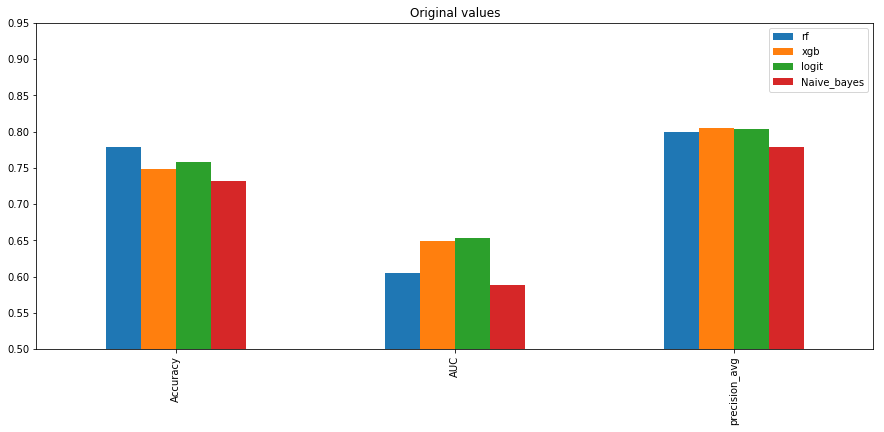

In [23]:
l_rf = pred(ensemble.RandomForestClassifier(min_samples_leaf=12,max_depth=8),f_train,f_test)
l_xgb = pred(xgb.XGBClassifier(),f_train,f_test)
l_log = pred(linear_model.LogisticRegressionCV(),f_train,f_test)
l_nb = pred(naive_bayes.GaussianNB(),f_train,f_test)
df_results = pd.DataFrame(index=['rf','xgb','logit','Naive_bayes'],data=[l_rf,l_xgb,l_log,l_nb],columns = ['Accuracy','AUC','precision_avg'])
df_results.T.plot(kind = 'bar',figsize = (15,6))
plt.title('Original values')
plt.ylim((0.5,0.95))


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5,1,'Zero values dropped')

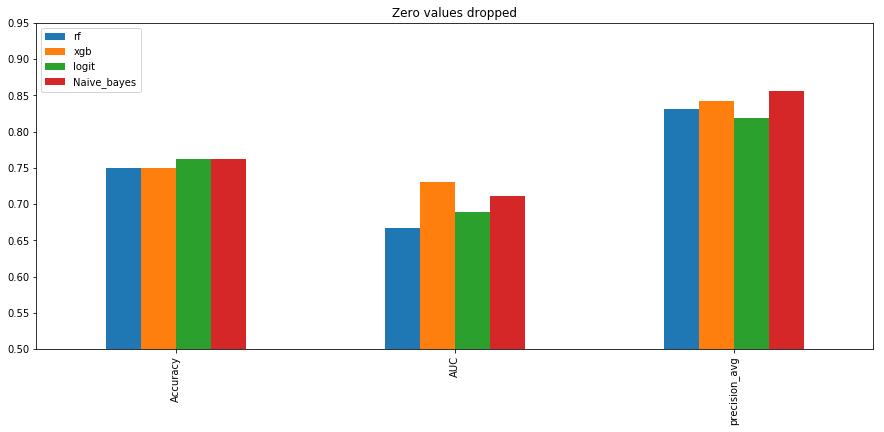

In [24]:
l_rf = pred(ensemble.RandomForestClassifier(min_samples_leaf=12,max_depth=8),f_drop_zero_train,f_drop_zero_test)
l_xgb = pred(xgb.XGBClassifier(),f_drop_zero_train,f_drop_zero_test)
l_log = pred(linear_model.LogisticRegressionCV(),f_drop_zero_train,f_drop_zero_test)
l_nb = pred(naive_bayes.GaussianNB(),f_drop_zero_train,f_drop_zero_test)
df_results = pd.DataFrame(index=['rf','xgb','logit','Naive_bayes'],data=[l_rf,l_xgb,l_log,l_nb],columns = ['Accuracy','AUC','precision_avg'])
df_results.T.plot(kind = 'bar',figsize = (15,6))
plt.ylim((0.5,0.95))
plt.title('Zero values dropped')


/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


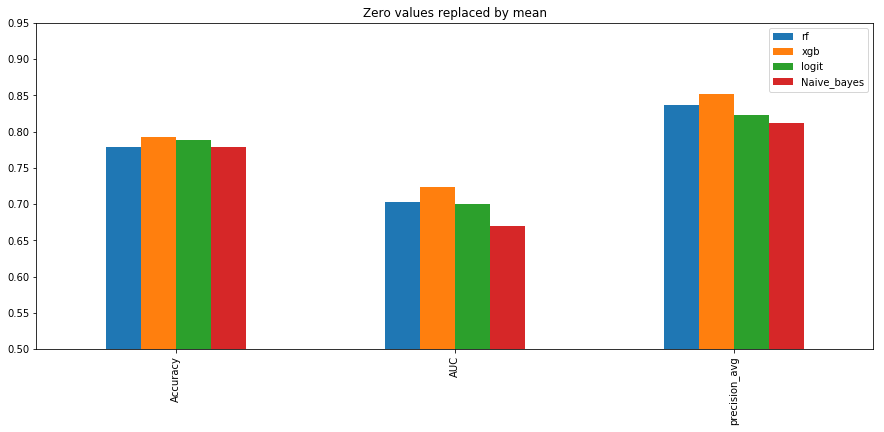

In [25]:
l_rf = pred(ensemble.RandomForestClassifier(min_samples_leaf=12,max_depth=8),f_impute_zero_train,f_impute_zero_test)
l_xgb = pred(xgb.XGBClassifier(),f_impute_zero_train,f_impute_zero_test)
l_log = pred(linear_model.LogisticRegressionCV(),f_impute_zero_train,f_impute_zero_test)
l_nb = pred(naive_bayes.GaussianNB(),f_impute_zero_train,f_impute_zero_test)
df_results = pd.DataFrame(index=['rf','xgb','logit','Naive_bayes'],data=[l_rf,l_xgb,l_log,l_nb],columns = ['Accuracy','AUC','precision_avg'])
df_results.T.plot(kind = 'bar',figsize = (15,6))
plt.ylim((0.5,0.95))
plt.title('Zero values replaced by mean')
plt.show()


In [26]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

def predict(model,f,train_index,test_index):
    model.fit(f.loc[train_index].drop('Outcome',1),f.loc[train_index,'Outcome'])
    auc = roc_auc_score(f.loc[test_index,'Outcome'],[i[1] for i in model.predict_proba(f.loc[test_index].drop('Outcome',1))])
    return model.score(f.loc[test_index].drop('Outcome',1),f.loc[test_index,'Outcome']),auc

ll = []
l = ['All','Imputed','Dropped']
for i,file in enumerate([f.sample(len(f)).reset_index(drop=True),f_impute_zeros.sample(len(f_impute_zeros)).reset_index(drop=True),f_dropped_zeros.sample(len(f_dropped_zeros)).reset_index(drop=True)]):
    #print (l[i],'\n')
    for model in [ensemble.RandomForestClassifier(min_samples_leaf=12,max_depth=8),
                 xgb.XGBClassifier(colsample_bytree=0.8),linear_model.LogisticRegression(),naive_bayes.GaussianNB()]:
        ll.append( [str(model).split('(')[0]] +[l[i]]+ pd.DataFrame([predict(model,file,train_index,test_index) for train_index,test_index in kf.split(file)]).mean().values.tolist())
    
df= pd.DataFrame(ll).pivot_table(columns = 0,index = 1,values = [2,3])
df

/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/oz/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

2                                                          \
0       GaussianNB LogisticRegression RandomForestClassifier XGBClassifier   
1                                                                            
All       0.747396           0.759115               0.746094      0.746094   
Dropped   0.760659           0.770274               0.799225      0.774120   
Imputed   0.742188           0.744792               0.752604      0.764323   

                 3                                                          
0       GaussianNB LogisticRegression RandomForestClassifier XGBClassifier  
1                                                                           
All       0.808010           0.817072               0.806759      0.825661  
Dropped   0.832821           0.831161               0.842708      0.832464  
Imputed   0.812060           0.820668               0.819865      0.831243

In [34]:
df[df.columns.levels==2]

KeyError: False

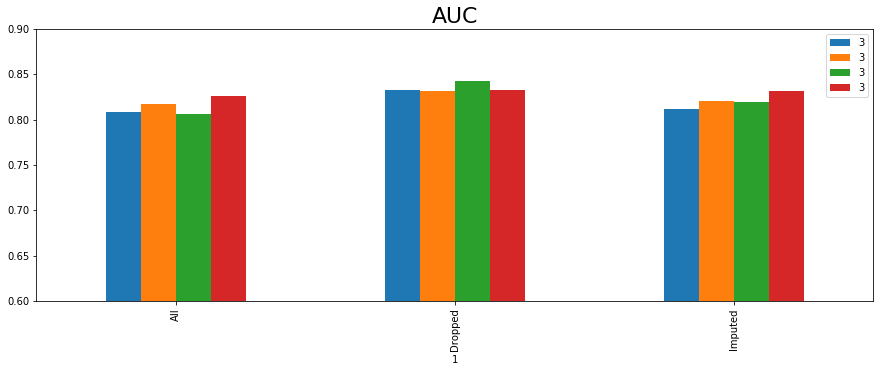

In [27]:
df[3].plot(kind='bar',figsize=(15,5))
plt.ylim((0.6,0.9))
plt.title('AUC',fontsize=22)
plt.show()

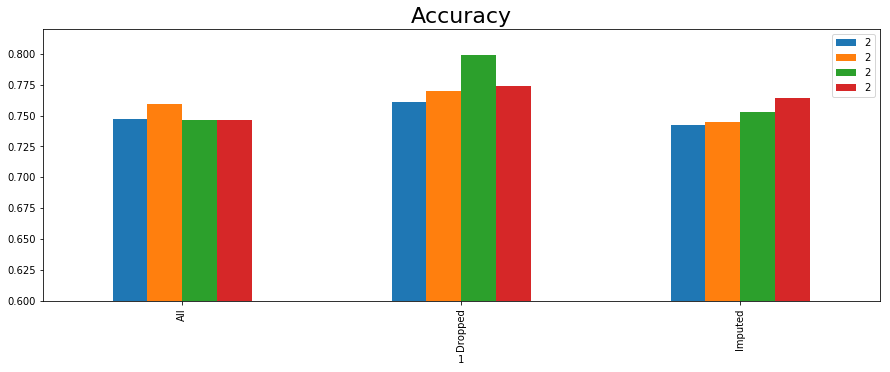

In [28]:
df[2].plot(kind='bar',figsize=(15,5))
plt.ylim((0.6,0.82))
plt.title('Accuracy',fontsize=22)
plt.show()

### Dropping 0 zalues is slightly better than imputing them - Probably since simple replacement to mean/median is not enough.


### Deal with un-balanced data

In [26]:
from imblearn import over_sampling , under_sampling

In [27]:
sm = over_sampling.SMOTE()
X_res, y_res = sm.fit_sample(f_train.drop('Outcome',1),f_train['Outcome'])

In [28]:
model = linear_model.LogisticRegression()
model.fit(X_res,y_res)
auc = roc_auc_score(f_test['Outcome'], [i[1] for i in model.predict_proba(f_test.drop('Outcome',1))])
print (model.score(f_test.drop('Outcome',1),f_test['Outcome']) , auc)

0.7489177489177489 0.8280313124583611


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
model = ensemble.RandomForestClassifier(min_samples_leaf=12,max_depth=8)
model.fit(X_res,y_res)
auc = roc_auc_score(f_test['Outcome'], [i[1] for i in model.predict_proba(f_test.drop('Outcome',1))])
print (model.score(f_test.drop('Outcome',1),f_test['Outcome']) , auc)

0.7445887445887446 0.8062125249833445


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Segmentation with Random forests - 200 estimators - ** Select the dropped Vs other cleansed files**

In [30]:
#train = f_drop_zero_train
#test = f_drop_zero_test
train = f_impute_zero_train
test = f_impute_zero_test

model = ensemble.RandomForestClassifier(min_samples_leaf=10,max_depth=3,n_estimators=200)
model.fit(train.drop('Outcome',1),train['Outcome'])
scr = model.score(test.drop('Outcome',1),test['Outcome'])
auc_score = roc_auc_score(test['Outcome'],[i[1] for i in model.predict_proba(test.drop('Outcome',1))])
avg_precision = average_precision_score(test['Outcome'],[i[1] for i in model.predict_proba(test.drop('Outcome',1))])

print (scr,auc_score,avg_precision)

0.7835497835497836 0.8267821452365091 0.7201199019638587


In [31]:
feature_names = pd.Series(train.columns)
feature_names[-2] = None

all_splits = pd.DataFrame(index=feature_names)


for i,tt in enumerate(model.estimators_):
    pp = pd.DataFrame(index = ['feature','split_point'], data=[tt.tree_.feature,tt.tree_.threshold]).T
    pp['feature_name'] = pp['feature'].map(feature_names)
    pp['split_point'] = pp['split_point'].apply(lambda x: float("%.1f" %x))
    all_splits[i] = pp.groupby('feature_name').apply(lambda x: x.split_point.values)

aa  =all_splits.T.apply(lambda x: list(np.hstack(x.values)))    
df_splits = pd.DataFrame(aa).T.apply(lambda x: pd.Series(x[0])).apply(lambda x: x.value_counts().to_dict())

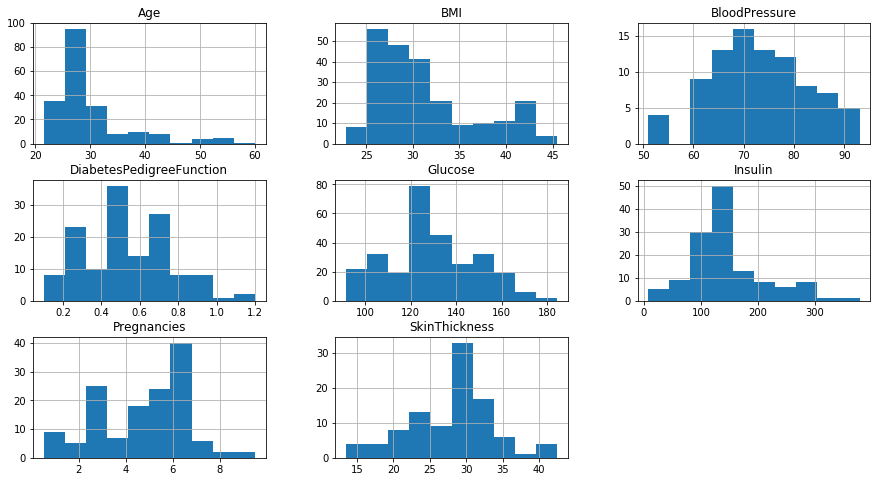

In [32]:
pd.DataFrame(aa).T.drop([None,'Outcome'],1).apply(lambda x: pd.Series(x[0])).hist(bins = 10,figsize = (15,8))
plt.show()

In [33]:
def get_splits(x):
    x = pd.Series(x)
    his = np.histogram(x.dropna())
    h1 = pd.Series(index=his[0],data=his[1][1:].tolist()).reset_index().reset_index().sort_values('index',ascending = False)
    
    # Take highest 2 bars and determine their distance and height ratio, If they far and similar height - show both:
    diff_peak = (h1.iloc[:2,1].diff().abs().tolist()[1] / h1.iloc[1,1]) < 0.15
    dist_peak = h1.iloc[:2,0].diff().abs().tolist()[1] > 2
    
    if (diff_peak and dist_peak):
        return (h1[0].iloc[:2].values)
    else:
        return ([h1[0].iloc[0].tolist()])

In [34]:
aa1 = aa.apply(get_splits)
print(aa1)

def calc_group(x):
    return pd.concat([x < i for i in aa1.loc[x.name]],1).sum(1)

t_segments = test.drop('Outcome',1).apply(calc_group)
t_segments['Outcome'] = test['Outcome']

print ('\n\nSegmented : ', t_segments.groupby(t_segments.drop('Outcome',1).columns.tolist())['Outcome'].std().mean(),
       '\nAll : ', t_segments['Outcome'].std())

Pregnancies                                [6.8]
Glucose                                  [128.7]
BloodPressure                             [72.0]
SkinThickness                             [30.9]
Insulin                                  [155.9]
BMI                                      [27.34]
DiabetesPedigreeFunction    [0.5399999999999999]
Age                                       [29.2]
Outcome                                    [0.1]
NaN                                        [0.1]
dtype: object


Segmented :  0.3051464411383176 
All :  0.4754068462800374


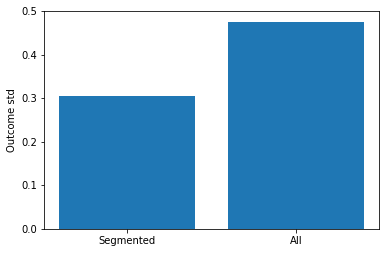

In [35]:
plt.bar([0,1],[ t_segments.groupby(t_segments.drop('Outcome',1).columns.tolist())['Outcome'].std().mean(),t_segments['Outcome'].std()])
plt.xticks([0,1],['Segmented','All'])
plt.ylabel('Outcome std')
plt.show()

### Find important interactions

In [36]:
list_relates = []
for i in range(len(model.estimators_)):
    estimator = model.estimators_[i]
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left # get all left children 
    children_right = estimator.tree_.children_right # get all right children
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold


    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # The root: (node id , parent depth)
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If not a leaf - add
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
            
            
            
    for i in range(n_nodes):
        if is_leaves[i]:
            None #print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else :
            if(feature_names[feature[children_left[i]]] ):
                list_relates.append((feature_names[feature[i]] ,feature_names[feature[children_left[i]]] ))
            if(feature_names[feature[children_right[i]]] ):
                list_relates.append((feature_names[feature[i]] ,feature_names[feature[children_right[i]]] ))
    

In [37]:
pd.Series(list_relates).append(pd.Series(list_relates).apply(lambda x: x[::-1])).value_counts()[::]

(Age, Glucose)                                          91
(Glucose, Age)                                          91
(Glucose, BMI)                                          90
(BMI, Glucose)                                          90
(Glucose, Glucose)                                      76
(BMI, Age)                                              73
(Age, BMI)                                              73
(DiabetesPedigreeFunction, Glucose)                     59
(Glucose, DiabetesPedigreeFunction)                     59
(Glucose, Insulin)                                      50
(Insulin, Glucose)                                      50
(Glucose, Pregnancies)                                  49
(Age, Insulin)                                          49
(Pregnancies, Glucose)                                  49
(Insulin, Age)                                          49
(BMI, Pregnancies)                                      43
(Pregnancies, BMI)                                      

In [38]:
bst = pd.Series(index = test.drop('Outcome',1).columns ,data=model.feature_importances_).sort_values(ascending=False)
bst

Glucose                     0.344706
Age                         0.189363
BMI                         0.178201
Pregnancies                 0.084788
Insulin                     0.075071
DiabetesPedigreeFunction    0.062924
SkinThickness               0.039430
BloodPressure               0.025518
dtype: float64

In [39]:
ttrain = train.copy()
ttest = test.copy()
for col in ['Glucose', 'Age', 'BMI']:
    ttrain[col+'_s'] = calc_group(ttrain[col])
    ttest[col+'_s'] = calc_group(ttest[col])

In [40]:
ttest['GlucXBMI'] = ttest['Glucose_s'].astype(str) + ttest['BMI_s'].astype(str)
ttrain['GlucXBMI'] = ttrain['Glucose_s'].astype(str) + ttrain['BMI_s'].astype(str)
ttrain = pd.concat([ttrain,pd.get_dummies(ttrain['GlucXBMI'],prefix='GlucXBMI')],1)
ttest = pd.concat([ttest,pd.get_dummies(ttest['GlucXBMI'],prefix='GlucXBMI')],1)

ttest['GlucXAge'] = ttest['Glucose_s'].astype(str) + ttest['Age_s'].astype(str)
ttrain['GlucXAge'] = ttrain['Glucose_s'].astype(str) + ttrain['Age_s'].astype(str)
ttrain = pd.concat([ttrain,pd.get_dummies(ttrain['GlucXAge'],prefix='GlucXAge')],1)
ttest = pd.concat([ttest,pd.get_dummies(ttest['GlucXAge'],prefix='GlucXAge')],1)

ttest['BMIXAge'] = ttest['BMI_s'].astype(str) + ttest['Age_s'].astype(str)
ttrain['BMIXAge'] = ttrain['BMI_s'].astype(str) + ttrain['Age_s'].astype(str)
ttrain = pd.concat([ttrain,pd.get_dummies(ttrain['BMIXAge'],prefix='BMIXAge')],1)
ttest = pd.concat([ttest,pd.get_dummies(ttest['BMIXAge'],prefix='BMIXAge')],1)

ttest = ttest.drop(['Glucose_s', 'BMI_s', 'Age_s'],1)
ttrain = ttrain.drop(['Glucose_s', 'BMI_s', 'Age_s'],1)

In [41]:
set(ttrain.columns) - set(ttest.columns)

set()

ttest['GlucXInsulin_01'] = 0

In [42]:
lr = linear_model.LogisticRegression()
lr.fit(ttrain.drop('Outcome',1),ttrain['Outcome'])
print(roc_auc_score(ttest['Outcome'], [i[1] for i in lr.predict_proba(ttest.drop('Outcome',1))]))
confusion_matrix(ttest['Outcome'], lr.predict(ttest.drop('Outcome',1)))

0.8527648234510327


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[126,  26],
       [ 26,  53]], dtype=int64)

In [43]:
lr = linear_model.LogisticRegression()
lr.fit(train.drop('Outcome',1),train['Outcome'])
print(roc_auc_score(test['Outcome'], [i[1] for i in lr.predict_proba(test.drop('Outcome',1))]))
confusion_matrix(test['Outcome'], lr.predict(test.drop('Outcome',1)))

0.8228680879413726


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[133,  19],
       [ 32,  47]], dtype=int64)

## Conclusions:
#### Besides a straightforward prediction, Random forests can provide very valuable domain insights:
* Best split points for continuous variables -> which ranges are most likely to axplain the outcome?
    * Derive new segments that can be used for further inspections.
    * Find new categories / sub-groups in each continuous variable.
* Interactions -> Which variables have higher impact when combined: 
    * Very useful for further research poprposes : find new hidden connections that may better explain the outome.
    * Improve linear (/logistic) regression models - vary useful when simple model is required.
